PROBLEM 2 : NNet supervised classification with tuned word vectors
Train a neural network on a sizeable subset of 20NG (say, at least 5 categories)

Download GloVe embeddings from https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation?select=glove.6B.100d.txt and do some basic simplification, e.g.

## read the dataset, tokenize and pad
from gensim.utils import simple_preprocess
import torch
tokens = list()
for text in ng_text:
tokens.append(simple_preprocess(text))
ng_vector_idx = torch.LongTensor([doc2ind(doc) for doc in ng_text])

where `ng_vector_idx` is a `torch.tensor` of integers representing the indices of the GloVe vectors from above, and `doc2ind` is a function you need. Note that you should not form the matrix of word embeddings explicitly, but simply specific vector-indices representing the words in the text (see `torch.Embedding` for more details)

Parameterize an embedding layer for GloVe. With pytorch, this looks something like:

from torch import nn
glove_emb = nn.Embedding.from_pretrained(< glove vectors from NG tags here >)
glove_emb.weight.requires_grad = False


Construct an Neural Network using the embedding layer. You're free to design the architecture of the network after that. For example, in PyTorch, the architecture code might look something similar too:

model = nn.Sequential(
   glove_emb,
   ...
   nn.Linear(..., num_classes),
   nn.Softmax(dim=1)
)

It's possible to get a test set accuracy around 63%.



Fine tune them on 20NG by making your embedding layer trainable, i.e. by unfreezing the weights. After a sufficient amount of training, plot a 2d projection of the resulting embeddings colored by class using your choice reduction (PCA, MDS, tSNE, etc.). Is there any perceptible difference between the embedding before and after tuning?
You can follow a tutorial such as
https://czarrar.github.io/Gensim-Word2Vec/
https://github.com/ashutoshsingh0223/mittens

In [24]:
# %pip install gensim
# %pip install cython

In [25]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from tqdm import tqdm

In [26]:
glove = pd.read_csv('glove.6B.100d.txt', sep=' ', quoting=3, header=None)
glove

# Append a new row for the <NULL> token
null_token = pd.DataFrame([['<NULL>'] + [0] * (glove.shape[1] - 1)], columns=glove.columns)
glove = pd.concat([glove, null_token], ignore_index=True)

In [27]:
glove

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,the,-0.038194,-0.244870,0.72812,-0.399610,0.083172,0.043953,-0.391410,0.334400,-0.57545,...,0.016215,-0.017099,-0.389840,0.87424,-0.725690,-0.510580,-0.520280,-0.14590,0.82780,0.270620
1,",",-0.107670,0.110530,0.59812,-0.543610,0.673960,0.106630,0.038867,0.354810,0.06351,...,0.349510,-0.722600,0.375490,0.44410,-0.990590,0.612140,-0.351110,-0.83155,0.45293,0.082577
2,.,-0.339790,0.209410,0.46348,-0.647920,-0.383770,0.038034,0.171270,0.159780,0.46619,...,-0.063351,-0.674120,-0.068895,0.53604,-0.877730,0.318020,-0.392420,-0.23394,0.47298,-0.028803
3,of,-0.152900,-0.242790,0.89837,0.169960,0.535160,0.487840,-0.588260,-0.179820,-1.35810,...,0.187120,-0.018488,-0.267570,0.72700,-0.593630,-0.348390,-0.560940,-0.59100,1.00390,0.206640
4,to,-0.189700,0.050024,0.19084,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.20135,...,-0.131340,0.058617,-0.318690,-0.61419,-0.623930,-0.415480,-0.038175,-0.39804,0.47647,-0.159830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399996,kronik,-0.094426,0.147250,-0.15739,0.071966,-0.298450,0.039432,0.021870,0.008041,-0.18682,...,-0.305450,-0.011082,0.118550,-0.11312,0.339510,-0.224490,0.257430,0.63143,-0.20090,-0.105420
399997,rolonda,0.360880,-0.169190,-0.32704,0.098332,-0.429700,-0.188740,0.455560,0.285290,0.30340,...,-0.044082,0.140030,0.300070,-0.12731,-0.143040,-0.069396,0.281600,0.27139,-0.29188,0.161090
399998,zsombor,-0.104610,-0.504700,-0.49331,0.135160,-0.363710,-0.447500,0.184290,-0.056510,0.40474,...,0.151530,-0.108420,0.340640,-0.40916,-0.081263,0.095315,0.150180,0.42527,-0.51250,-0.170540
399999,sandberger,0.283650,-0.626300,-0.44351,0.217700,-0.087421,-0.170620,0.292660,-0.024899,0.26414,...,0.138850,-0.228620,0.071792,-0.43208,0.539800,-0.085806,0.032651,0.43678,-0.82607,-0.157010


In [28]:
#import 20 news groups
from sklearn.datasets import fetch_20newsgroups

# remove 14 categories (so that we only have 7 categories)
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.windows.x', 'sci.space']
ng_text = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
ng_text_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

print(ng_text.target_names)
print(len(ng_text.data))
print(len(ng_text_test.data))

# # TRUNCATE TO TEST:
# ng_text.data = ng_text.data[:50]
# ng_text.target = ng_text.target[:50]
# # print(len(ng_text.data))
# ng_text_test.data = ng_text_test.data[:50]
# ng_text_test.target = ng_text_test.target[:50]
# # inspect longest document
# print(max([len(doc.split()) for doc in ng_text.data]))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.windows.x', 'sci.space']
2841
1891


In [29]:
# ## read the dataset, tokenize and pad
# from gensim.utils import simple_preprocess
# import torch
# tokens = list()  # create a null token, place it at the end of the glove


# for text in ng_text.data:  # Use ng_text.data to access the text data
#     tokens.append(simple_preprocess(text))  # Ensure the input is a string

# from torch.nn.utils.rnn import pad_sequence

# # Convert the list of indices to a list of tensors
# indexed_tokens = [torch.LongTensor(doc2ind(doc)) for doc in tqdm(tokens)]

# # Pad the sequences to ensure uniform length
# ng_vector_idx = pad_sequence(indexed_tokens, batch_first=True, padding_value=400000)  # Use the index of the <NULL> token for padding

# # # Convert to LongTensor
# # ng_vector_idx = padded_tokens.long()

# print(ng_vector_idx)  # Print/inspect indices
# print(ng_vector_idx.shape)  # Print shape of the tensor

# # where `ng_vector_idx` is a `torch.tensor` of integers representing the indices of the GloVe vectors from above, and `doc2ind` is a function you need. 
# # Note that you should not form the matrix of word embeddings explicitly, but simply specific vector-indices representing the words in the text (see `torch.Embedding` for more details)

# # Alright, this takes too long. 

In [30]:
# To shorten calculation: Find OOV (Out of Vocabulary) words by comparing words within 20ng and Glove. 

# Create a set of all words in the GloVe dataset
glove_words = set(glove[0].values)
print(f"Number of words in GloVe: {len(glove_words)}")

# Create a set of all words in the 20 Newsgroups dataset
ng_words = set()
for text in ng_text.data:
    ng_words.update(simple_preprocess(text))  # Ensure the input is a string

print(f"Number of words in 20 Newsgroups: {len(ng_words)}")

# Find the OOV words
oov_words = ng_words - glove_words
print(f"Number of OOV words: {len(oov_words)}")
# OOV ratio:
oov_ratio = len(oov_words) / len(ng_words)
print(f"OOV ratio: {oov_ratio:.2%}")
print(f"This means that {len(oov_words)} words are not in the GloVe dataset, which is about {oov_ratio:.2%} of the total {len(ng_words)} words in the 20 Newsgroups dataset.")

common_words = ng_words & glove_words
print(f"Number of common words: {len(common_words)}")

print(f"Verify: {len(common_words) + len(oov_words)} == {len(ng_words)}")

# drop words from the GloVe dataset so that we only have the words in the 20 Newsgroups dataset
glove = glove[glove[0].isin(common_words)] # this is a very slow operation, so we will not do this
print(len(glove)) # should only be common words! 



Number of words in GloVe: 399999
Number of words in 20 Newsgroups: 37906
Number of OOV words: 14686
OOV ratio: 38.74%
This means that 14686 words are not in the GloVe dataset, which is about 38.74% of the total 37906 words in the 20 Newsgroups dataset.
Number of common words: 23220
Verify: 37906 == 37906
23220


In [31]:
# Now, append a new row for the <NULL> token
null_token = pd.DataFrame([['<NULL>'] + [0] * (glove.shape[1] - 1)], columns=glove.columns)
glove = pd.concat([glove, null_token], ignore_index=True)
# Get the index:
glove_index = glove.index[glove[0] == '<NULL>'][0]
print(glove_index) 
print(len(glove))

23220
23221


In [32]:
GLOVE_PATH = 'glove.6B.100d.txt'  # Path to GloVe file, if you have it locally
EMBED_DIM = 100  # Dimension of GloVe embeddings (6B.100d)

def load_glove(text_data):
    """Load GloVe embeddings for words in the dataset"""
    # Get all unique words from the dataset
    all_words = set()
    for doc in text_data:
        words = simple_preprocess(doc)
        all_words.update(words)
   
    print(f"Total unique words in corpus: {len(all_words)}")
   
    # Load embeddings for words in our dataset
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}
    embeddings = [
        np.zeros(EMBED_DIM),  # PAD
        np.random.normal(scale=0.1, size=EMBED_DIM)  # UNK
    ]
   
    idx = 2
    found_words = 0
   
    with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
           
            if word in all_words:
                vector = np.array(values[1:], dtype=np.float32)
                embeddings.append(vector)
                word_to_idx[word] = idx
                idx += 1
                found_words += 1
   
    print(f"Words found in GloVe: {found_words}")
    print(f"OOV ratio: {1 - (found_words / len(all_words)):.4f}")
   
    # Convert to tensor
    embeddings_matrix = torch.tensor(np.array(embeddings), dtype=torch.float)
    return embeddings_matrix, word_to_idx
 

def preprocess_data(docs, word_to_idx, max_length=None):
    """Convert documents to sequences of word indices and pad them"""
    sequences = []
    for doc in docs:
        words = simple_preprocess(doc)
        seq = [word_to_idx.get(word, 1) for word in words]  # Use 1 for unknown words
        sequences.append(seq)
   
    # Find max length if not provided
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)
   
    # Pad sequences
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_length:
            padded_sequences.append(seq[:max_length])
        else:
            padded_sequences.append(seq + [0] * (max_length - len(seq)))
   
    return torch.tensor(padded_sequences, dtype=torch.long), max_length

In [52]:
all_docs = ng_text.data + ng_text_test.data
# Load GloVe embeddings
embedding_matrix, word_to_idx = load_glove(all_docs)

# Preprocess train data
X_train_padded, max_length = preprocess_data(ng_text.data, word_to_idx)
y_train = torch.tensor(ng_text.target, dtype=torch.long)

# Preprocess test data
X_test_padded, _ = preprocess_data(ng_text_test.data, word_to_idx, max_length)
# use clone detatch
y_test = torch.tensor(ng_text_test.target, dtype=torch.long)


# now set names:
ng_vector_idx = X_train_padded  # Use the preprocessed train data for the model input
ng_vector_idx_test = X_test_padded  # Use the preprocessed test data for evaluation


Total unique words in corpus: 51279
Words found in GloVe: 29086
OOV ratio: 0.4328


C:\Users\koola\AppData\Local\Temp\ipykernel_10044\128975562.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(ng_text_test.target, dtype=torch.long)


In [34]:
# print(doc2ind(simple_preprocess(ng_text.data[0]))) # simple preprocess ensures lowercase
# print(ng_text.data[0])
# print(glove[glove[0] == 'are'].index[0]) # Index 32 is the word 'are'
# print(ng_vector_idx[0]) # should be the same as above, but now we have a tensor of indices

In [54]:
glove_emb = nn.Embedding.from_pretrained(ng_vector_idx.float(), freeze=True)
glove_emb.weight.requires_grad = False
# temp = torch.LongTensor(glove.iloc[:, 1:].values)
# print(temp.dtype)  # Check the type of the tensor
# print(ng_vector_idx[0].dtype)  # Check the type of the tensor
# print(glove_emb.weight[0])  # this is the embedding for 
# print(len(glove_emb.weight[0]))  
# print(len(glove_emb.weight))
print(glove_emb.weight.shape)

torch.Size([2841, 12740])


In [36]:
# # Perform the same for test data
# words_test = []  # our list of words
# for doc in tqdm(ng_text_test.data):  
#     words_test.append(simple_preprocess(doc))  # Ensure the input is a string
#     seq = doc2ind(words_test[-1])  # Convert to indices

# # Convert the list of indices to a list of tensors
# indexed_tokens_test = [torch.LongTensor(doc2ind(doc)) for doc in tqdm(words_test)]

# # Pad the sequences to ensure uniform length
# ng_vector_idx_test = pad_sequence(indexed_tokens_test, batch_first=True, padding_value=glove_index)  # Use the index of the <NULL> token for padding



In [37]:
# Plot AFTER training
# document embedding 
# how different categories of documents are clustered in the embedding space
# use tSNE/PCA 

# 2 Phases: 
    # 1. Frozen Embeddings. 
    # 2. Unfrozen Embeddings. 
# Word embeddings: Dictionary. links word to numbers
# NN: Recipe. How much of each ingredient(using the dictionary) to use



In [55]:
# Model definition:
class GloveEmbeddedModel(nn.Module):
    def __init__(self, glove_emb):
        super(GloveEmbeddedModel, self).__init__()
        self.embedding = glove_emb
        self.fc1 = nn.Linear(glove_emb.weight.shape[1], 128)
        self.dropout = nn.Dropout(oov_ratio) # Dropout layer with OOV ratio as dropout probability
        nn.ReLU(),
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1) # Average over ALL words in the document (where each word has an embedding of 100 dimensions)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x)
        return x


In [ ]:
## Pt.1: Frozen Embeddings

# Initialize the model
frozen_model = GloveEmbeddedModel(glove_emb)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(frozen_model.parameters(), lr=0.001)

# Convert the target labels to LongTensor
ng_target = torch.LongTensor(ng_text.target)  # Convert to LongTensor
ng_text_test.target = torch.LongTensor(ng_text_test.target)  # Convert to LongTensor



# Ensure indices are within the valid range for the embedding layer
max_index = glove_emb.num_embeddings - 1
ng_vector_idx = torch.clamp(ng_vector_idx, 0, max_index)
ng_vector_idx_test = torch.clamp(ng_vector_idx_test, 0, max_index)

# Create a DataLoader for batching
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Data Loaders:
train_set = TensorDataset(ng_vector_idx, ng_target)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_set = TensorDataset(ng_vector_idx_test, ng_text_test.target)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# train the model
num_epochs = 20
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = frozen_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = frozen_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f"Accuracy of the model on the test set: {accuracy:.2f}%")


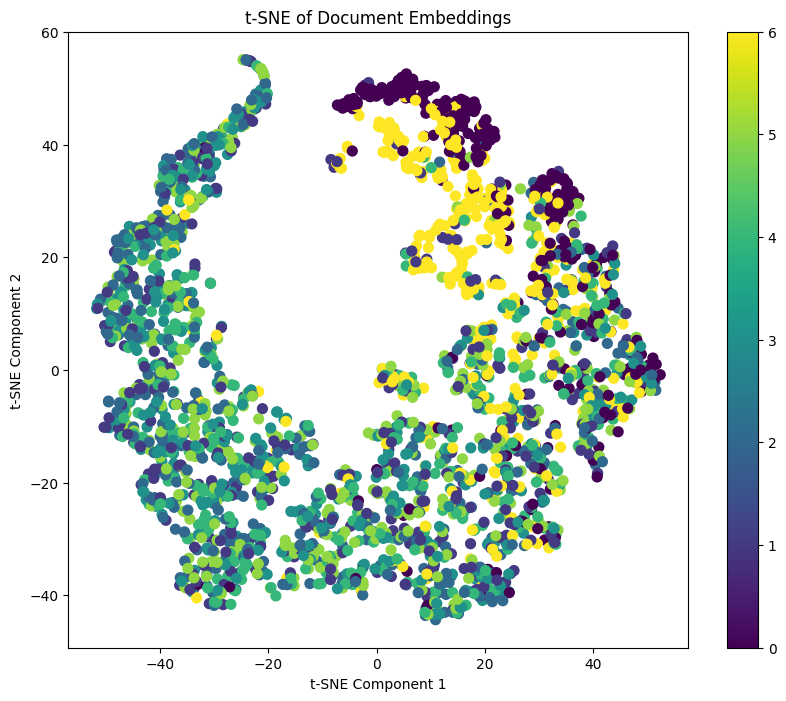

In [ ]:
# Plot a 2-d projection of the resulting embeddings colored by class using your choice reduction (PCA, MDS, tSNE)
from sklearn.manifold import TSNE


# Get the embeddings for the test set
test_embeddings = []
for inputs, labels in test_loader:
    with torch.no_grad():
        outputs = frozen_model(inputs)
        test_embeddings.append(outputs.numpy())

# Concatenate the embeddings into a single array
test_embeddings = np.concatenate(test_embeddings, axis=0)

# Get the labels for the test set
test_labels = []
for inputs, labels in test_loader:
    test_labels.append(labels.numpy())

# Concatenate the labels into a single array
test_labels = np.concatenate(test_labels, axis=0)

# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=0)
test_embeddings_2d = tsne.fit_transform(test_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], c=test_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('t-SNE of Document Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()




In [ ]:
# Now, lets unfreeze embeddings!

# Reinitialize the embeddings:
glove_emb = nn.Embedding.from_pretrained(torch.FloatTensor(glove.iloc[:, 1:].values), freeze=False)
glove_emb.weight.requires_grad = False

# Initialize the model
unfrozen_model = GloveEmbeddedModel(glove_emb)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unfrozen_model.parameters(), lr=0.001)

# train the model
num_epochs = 10

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = unfrozen_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = unfrozen_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the model on the test set: {accuracy:.2f}%")


Epoch [1/10], Step [10/2005], Loss: 1.9613
Epoch [1/10], Step [20/2005], Loss: 1.9791
Epoch [1/10], Step [30/2005], Loss: 1.9725
Epoch [1/10], Step [40/2005], Loss: 1.9719
Epoch [1/10], Step [50/2005], Loss: 1.9339
Epoch [1/10], Step [60/2005], Loss: 1.9415
Epoch [1/10], Step [70/2005], Loss: 2.0589
Epoch [1/10], Step [80/2005], Loss: 1.9592
Epoch [1/10], Step [90/2005], Loss: 1.9838
Epoch [1/10], Step [100/2005], Loss: 1.9334
Epoch [1/10], Step [110/2005], Loss: 1.9888
Epoch [1/10], Step [120/2005], Loss: 1.9102
Epoch [1/10], Step [130/2005], Loss: 1.9304
Epoch [1/10], Step [140/2005], Loss: 1.8960
Epoch [1/10], Step [150/2005], Loss: 1.9251
Epoch [1/10], Step [160/2005], Loss: 1.9708
Epoch [1/10], Step [170/2005], Loss: 1.9428
Epoch [1/10], Step [180/2005], Loss: 1.9842
Epoch [1/10], Step [190/2005], Loss: 1.9082
Epoch [1/10], Step [200/2005], Loss: 1.9364
Epoch [1/10], Step [210/2005], Loss: 1.9900
Epoch [1/10], Step [220/2005], Loss: 1.9529
Epoch [1/10], Step [230/2005], Loss: 1.93

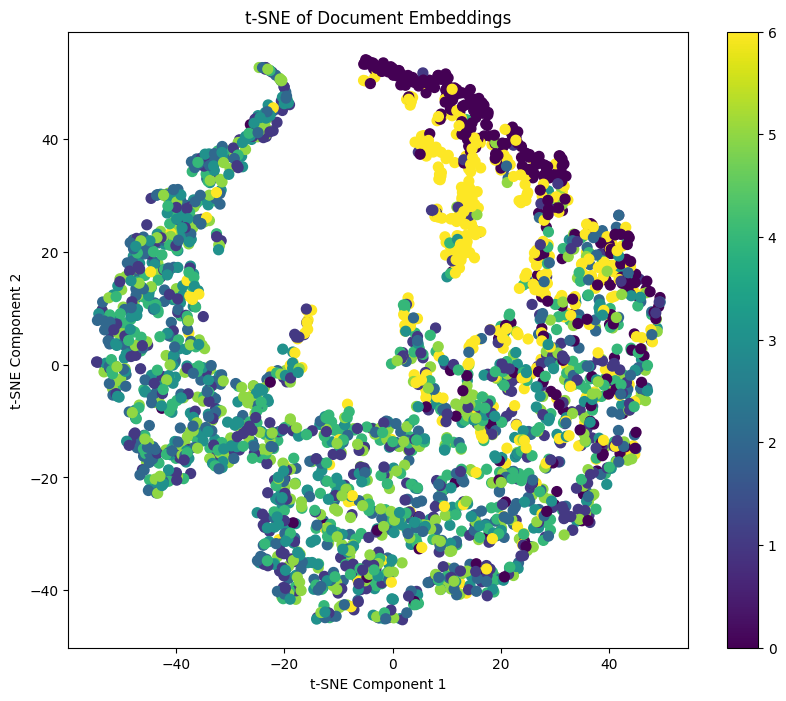

In [ ]:
# Plot a 2-d projection of the resulting embeddings colored by class using your choice reduction (PCA, MDS, tSNE)
from sklearn.manifold import TSNE


# Get the embeddings for the test set
test_embeddings = []
for inputs, labels in test_loader:
    with torch.no_grad():
        outputs = frozen_model(inputs)
        test_embeddings.append(outputs.numpy())

# Concatenate the embeddings into a single array
test_embeddings = np.concatenate(test_embeddings, axis=0)

# Get the labels for the test set
test_labels = []
for inputs, labels in test_loader:
    test_labels.append(labels.numpy())

# Concatenate the labels into a single array
test_labels = np.concatenate(test_labels, axis=0)

# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=0)
test_embeddings_2d = tsne.fit_transform(test_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], c=test_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('t-SNE of Document Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


